# Approximating Levy Stable log density

In [43]:
import math
import numpy as np
from scipy.stats import levy_stable
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.linewidth'] = 0.1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levy_stable.html
levy_stable.parameterization = "S0"

In [6]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def logit(x):
    return np.log(x) - np.log1p(-x)

def _():
    x = np.linspace(-10, 10, 100)
    assert np.allclose(x, logit(sigmoid(x)))
_()

In [54]:
a_grid = [0.1, 0.2, 0.5, 1.0, 1.5, 1.8, 2.0]
b_grid = [0.0, 0.2, 0.5, 0.8, 0.9, 1.0]
x_grid = [-4.0, -1.0, -0.25, 0.0, 0.25, 1.0, 4.0]

Let's build up some intuition by visualizing the density on a transformed real line `x = atanh(reals)`.

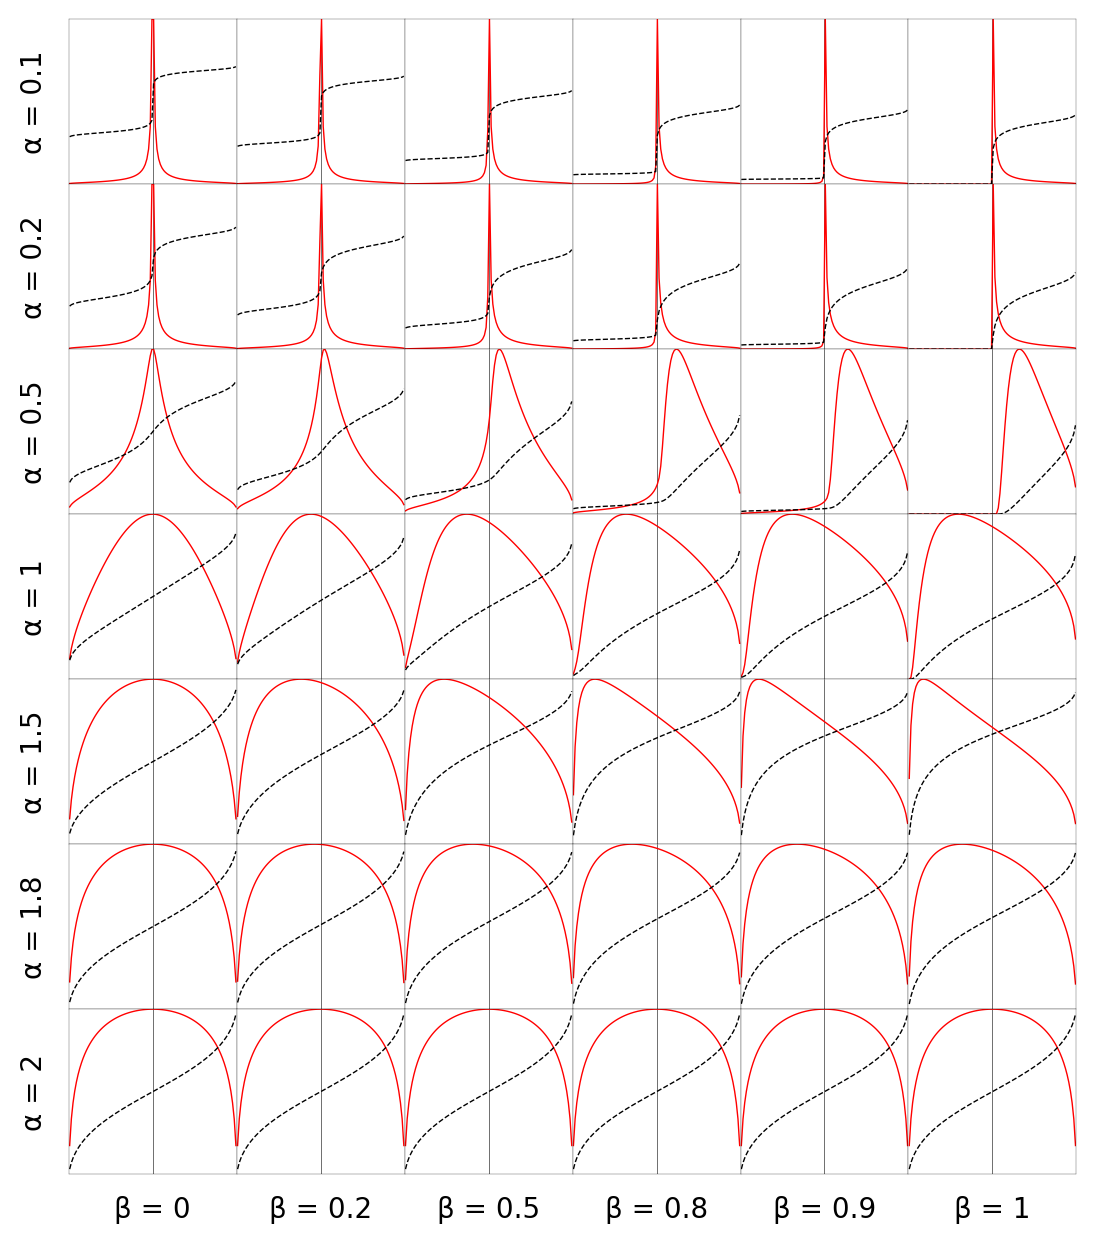

In [55]:
def plot_density(n=100):
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)
    fig, axes = plt.subplots(
        len(a_grid), len(b_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(b_grid), 0.5 + len(a_grid)), dpi=200)
    for i, a in enumerate(a_grid):
        for j, b in enumerate(b_grid):
            ax = axes[i][j]
            ax.axvline(0, lw=0.2, color="k")
            p = levy_stable(a, b).pdf(x)
            p /= p.max()
            ax.plot(u, p, "r-", lw=0.5)
            c = levy_stable(a, b).cdf(x)
            ax.plot(u, c, "k--", lw=0.5)
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(a_grid) - 1:
                ax.set_xlabel(f"β = {b:0.3g}")
            if j == 0:
                ax.set_ylabel(f"α = {a:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)
plot_density()

Now let's try to make the cdf easier to approximate by transforming both the x and y axes while preserving the asymptotic power law behavior of tails, namely that ([Nolan (2020)](https://edspace.american.edu/jpnolan/stable/) ss. 1.5 pp. 13 thm. 1.2) if $X\sim S(\alpha,\beta,\gamma,\delta;0)$ then
$$
P(X > x) \sim \gamma^\alpha c_\alpha (1+\beta) x^{-\alpha}
$$
where
$$
c_\alpha = \sin\left(\frac {\pi\alpha} 2\right)\Gamma(\alpha)/\pi
$$

Now using `sinh` and `asinh` as two-sided analogs of `exp` and `log` respectively, we want to find a coordinate system `x(z)` close to the cdf, i.e. so that `cdf(x(z))` is close to `z`. Assuming a standard location and scale ($\gamma=1$, $\delta=0$), we solve
\begin{align*}
x &\sim c_\alpha (1+\beta) z^{-\alpha} \\
  &:= c z^{-\alpha} \\
\operatorname{asinh}(x / c) &= -\alpha \operatorname{asinh}(z) \\
-\operatorname{sinh}(\operatorname{asinh}(x / c) / \alpha) &= z
\end{align*}

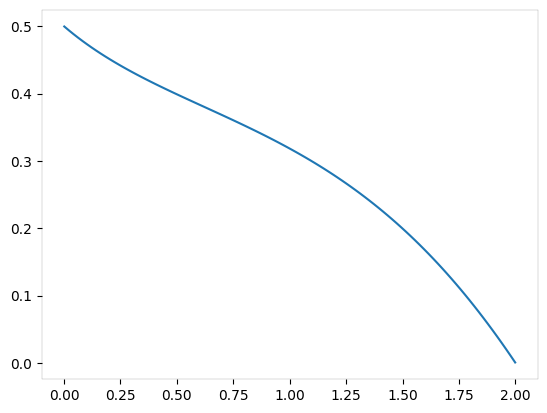

In [49]:
def plot_ca(eps=1e-3):
    a = np.linspace(0 + eps, 2 - eps, 100)
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    plt.plot(a, ca)
plot_ca()

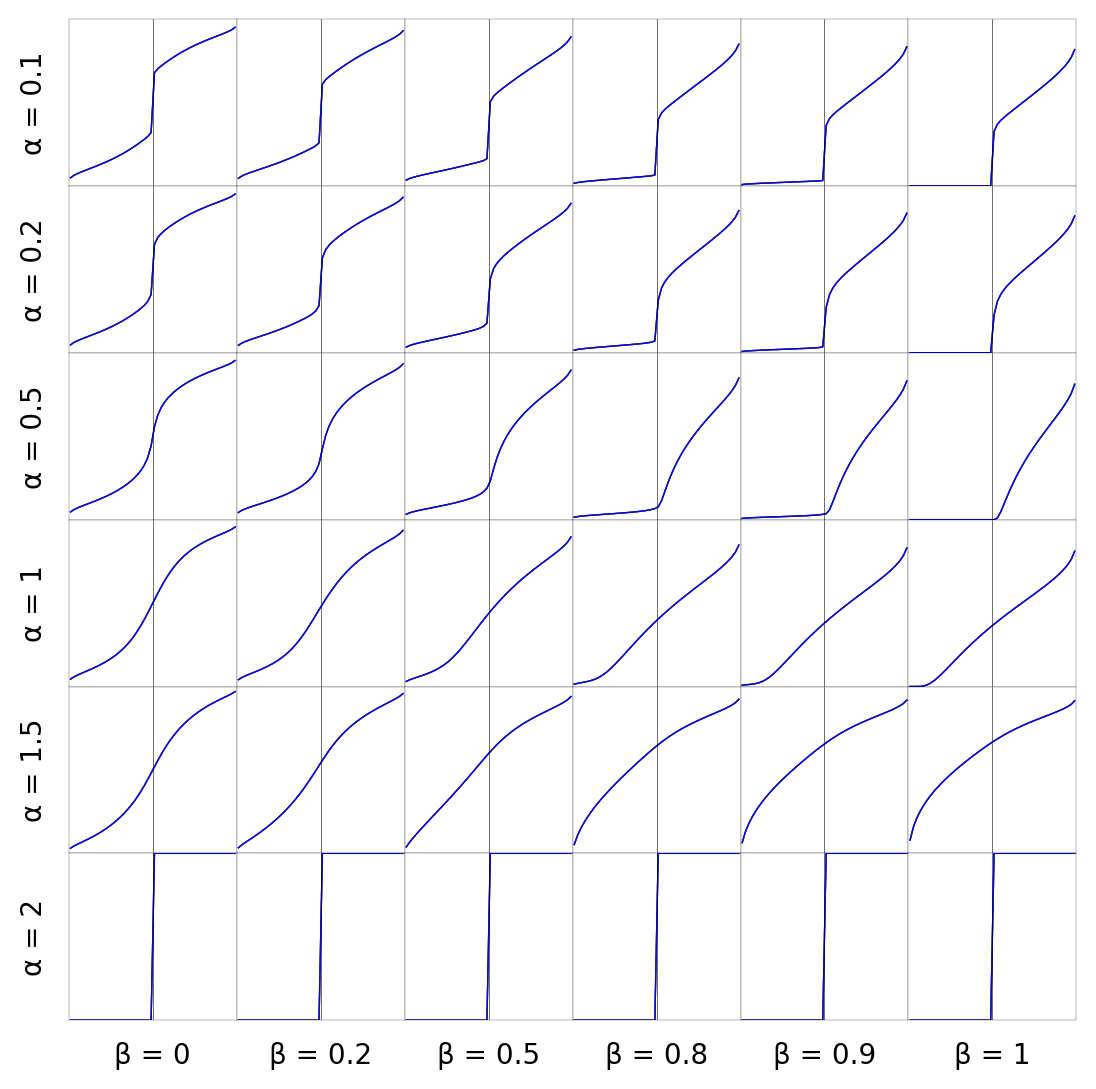

In [53]:
def plot_transformed_cdf(n=50):
    focii = [0.0, 0.5, 1.0]
    colors = ["red", "green", "blue"]
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)  # like logit(-) but symmetric
    fig, axes = plt.subplots(
        len(a_grid), len(b_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(b_grid), 0.5 + len(a_grid)), dpi=200)
    for i, a in enumerate(a_grid):
        ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
        for j, b in enumerate(b_grid):
            c = ca * (1 + b)
            ax = axes[i][j]
            for focus, color in zip(focii, colors):
                z = np.sinh(np.arcsinh(x / c) / a)
                v = levy_stable(a, b).cdf(z)
                ax.plot(u, v, color=color, lw=0.5)
            ax.axvline(0, lw=0.2, color="k")
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(a_grid) - 1:
                ax.set_xlabel(f"β = {b:0.3g}")
            if j == 0:
                ax.set_ylabel(f"α = {a:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)
plot_transformed_cdf()